# Combined Training Notebook

This notebook combines the functionality from main.ipynb and train_with_conf.ipynb to run both training approaches sequentially.

# Part 1: Main Training Pipeline (from main.ipynb)

In [1]:
# Import required libraries
import os
import pandas as pd
import numpy as np
import torch
from model_builder import create_dnn_model, create_cnn_model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from model_builder import SimpleDNN, SimpleCNN
import torch.nn.functional as F
from plotter import visualize_tissue_image_with_samples, visualize_tissue_image_with_samples_color_labels

input_csv = "training_data/WSI_patch_embeddings_centered-224_adenocarcinoma_leiden_0.3_training-data.csv"
df = pd.read_csv(input_csv)

# Settings: 
do_pca = True

# Using variance explained percentages instead of fixed component numbers
pca_dimensions = [0.80, 0.85, 0.90, 0.95]  # 80%, 85%, 90%, 95% variance explained

# Legacy setting (not used anymore when do_pca=True)
pca_components = 10  # This is now ignored when using variance-based PCA

epochs = 30
output_base_path = "models/"
output_path_extra_desciptor = "" # leave empty if not needed; 
ebbeding_dim = 1536
result_subfolder = "leiden_0.3_adenocarcinoma_224"

Get pathology training data

In [2]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

feature_cols = [str(i) for i in range(1536)]
X = df[feature_cols].values.astype(np.float32)

scaler = StandardScaler()
X = scaler.fit_transform(X).astype(np.float32)
y = LabelEncoder().fit_transform(df['label'].values).astype(np.int64)
labelEncoder = LabelEncoder().fit(df['label'].values)

# Create train/validation/test splits (60/20/20)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)  # 0.25 * 0.8 = 0.2

print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/len(X)*100:.1f}%)")

df = pd.read_csv(input_csv)
X_pcaList = []
X_val_pcaList = []
X_test_pcaList = []

# Using variance explained (0.80 = 80% variance, etc.)
variance_explained_ratios = [0.80, 0.85, 0.90, 0.95]
pca_component_numbers = []  # Will store actual component numbers for each variance ratio

print(f"Using PCA with variance explained ratios: {[f'{v*100}%' for v in variance_explained_ratios]}")

for variance_explained in variance_explained_ratios:
    pca = PCA(n_components=variance_explained)  # This will automatically determine n_components
    X_train_pca = pca.fit_transform(X_train)
    X_val_pca = pca.transform(X_val)
    X_test_pca = pca.transform(X_test)
    
    actual_components = pca.n_components_
    actual_variance = pca.explained_variance_ratio_.sum()
    pca_component_numbers.append(actual_components)
    
    print(f"PCA with {variance_explained*100}% variance target uses {actual_components} components")
    print(f"Actual variance explained: {actual_variance:.3f} ({actual_variance*100:.1f}%)")
    print(f"Shape: {X_train_pca.shape}")
    print("")
    
    X_pcaList.append(X_train_pca)
    X_val_pcaList.append(X_val_pca)
    X_test_pcaList.append(X_test_pca)

Training set size: 2622 (60.0%)
Validation set size: 874 (20.0%)
Test set size: 875 (20.0%)
Using PCA with variance explained ratios: ['80.0%', '85.0%', '90.0%', '95.0%']
PCA with 80.0% variance target uses 139 components
Actual variance explained: 0.801 (80.1%)
Shape: (2622, 139)

PCA with 85.0% variance target uses 198 components
Actual variance explained: 0.850 (85.0%)
Shape: (2622, 198)

PCA with 90.0% variance target uses 296 components
Actual variance explained: 0.900 (90.0%)
Shape: (2622, 296)

PCA with 95.0% variance target uses 490 components
Actual variance explained: 0.950 (95.0%)
Shape: (2622, 490)



Train DNN model

In [3]:
dnn_list = []
# Note: model_builder functions return validation accuracy, not training accuracy
if do_pca:
    print("Training DNN models with PCA for dimensionality reduction...")
    for i, X_train_pca in enumerate(X_pcaList):
        current_components = X_train_pca.shape[1]  # Get actual number of components
        print(f"Shape of PCA transformed data: {X_train_pca.shape}")
        
        dnn_output_path = f"{output_base_path}/dnn_pathology_model_pca_{current_components}.pth"
        model, _ = create_dnn_model(X_train_pca, X_val_pcaList[i], y_train, y_val, dnn_output_path, labelEncoder, 
                                   inputDim=current_components, epochs=epochs)
        dnn_list.append(model)
        print(f"Training set size: {X_train_pca.shape[0]}")
        print(f"Validation set size: {X_val_pcaList[i].shape[0]}")
        print("")
        
# Train model without PCA        
dnn_output_path = f"{output_base_path}/dnn_pathology_model_without_pca.pth"
dnn_without_pca, _ = create_dnn_model(X_train, X_val, y_train, y_val, dnn_output_path, labelEncoder, 
                                      inputDim=ebbeding_dim, epochs=epochs)
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training DNN models with PCA for dimensionality reduction...
Shape of PCA transformed data: (2622, 139)
DNN: Epoch 1 completed. Average Loss: 1.0936
DNN: Epoch 2 completed. Average Loss: 0.6283
DNN: Epoch 3 completed. Average Loss: 0.5233
DNN: Epoch 4 completed. Average Loss: 0.4435
DNN: Epoch 5 completed. Average Loss: 0.4054
DNN: Epoch 6 completed. Average Loss: 0.3663
DNN: Epoch 7 completed. Average Loss: 0.3354
DNN: Epoch 8 completed. Average Loss: 0.3351
DNN: Epoch 9 completed. Average Loss: 0.3018
DNN: Epoch 10 completed. Average Loss: 0.2928
DNN: Epoch 11 completed. Average Loss: 0.2651
DNN: Epoch 12 completed. Average Loss: 0.2512
DNN: Epoch 13 completed. Average Loss: 0.2329
DNN: Epoch 14 completed. Average Loss: 0.2242
DNN: Epoch 15 completed. Average Loss: 0.2071
DNN: Epoch 16 completed. Average Loss: 0.2061
DNN: Epoch 17 completed. Average Loss: 0.1768
DNN: Epoch 18 completed. Average Loss: 0.1785
DNN: Epoch 19 completed. Average Loss: 0.1625
DNN: Epoch 20 completed. Averag

In [4]:
# Evaluate DNN models on validation set
from sklearn.metrics import adjusted_rand_score, f1_score, accuracy_score

# Get predictions for validation data
original_labels = labelEncoder.classes_.tolist()
list_of_prediced_labels_dnn = []
ari_score_list_dnn = []
f1_score_list_dnn = []
accuracy_list_dnn = []

for i, dnn_model in enumerate(dnn_list):
    # Get validation predictions for each dnn_model
    X_val_tensor = torch.tensor(X_val_pcaList[i]).float()
    with torch.no_grad():
        dnn_outputs_temp = dnn_model(X_val_tensor)
        temp = F.softmax(dnn_outputs_temp, dim=1).argmax(dim=1)
        # list comprehension of predicted labels
        prediced_labels = [original_labels[label] for label in temp.numpy()]
        list_of_prediced_labels_dnn.append(prediced_labels)
    
    # Calculate validation metrics
    ari_score = adjusted_rand_score(y_val, prediced_labels)
    f1_score_val = f1_score(y_val, prediced_labels, average='weighted')
    accuracy_val = accuracy_score(y_val, prediced_labels)
    
    ari_score_list_dnn.append(ari_score)
    f1_score_list_dnn.append(f1_score_val)
    accuracy_list_dnn.append(accuracy_val)
    
    print(f"DNN PCA {i+1} - Validation Accuracy: {accuracy_val:.3f}, ARI: {ari_score:.3f}, F1: {f1_score_val:.3f}")

# Evaluate DNN without PCA on validation set
X_val_tensor = torch.tensor(X_val).float()
with torch.no_grad():
    dnn_outputs = dnn_without_pca(X_val_tensor)
    dnn_preds_enc = F.softmax(dnn_outputs, dim=1).argmax(dim=1)
predicted_labels_dnn_no_pca = [original_labels[label] for label in dnn_preds_enc.numpy()]

# Calculate validation metrics for DNN without PCA
ari_dnn_no_pca = adjusted_rand_score(y_val, predicted_labels_dnn_no_pca)
f1_dnn_no_pca = f1_score(y_val, predicted_labels_dnn_no_pca, average='weighted')
accuracy_dnn_no_pca = accuracy_score(y_val, predicted_labels_dnn_no_pca)

print(f"DNN without PCA - Validation Accuracy: {accuracy_dnn_no_pca:.3f}, ARI: {ari_dnn_no_pca:.3f}, F1: {f1_dnn_no_pca:.3f}")

DNN PCA 1 - Validation Accuracy: 0.879, ARI: 0.768, F1: 0.878
DNN PCA 2 - Validation Accuracy: 0.868, ARI: 0.748, F1: 0.867
DNN PCA 3 - Validation Accuracy: 0.858, ARI: 0.723, F1: 0.856
DNN PCA 4 - Validation Accuracy: 0.866, ARI: 0.740, F1: 0.866
DNN without PCA - Validation Accuracy: 0.875, ARI: 0.752, F1: 0.875


Train CNN model

In [5]:
cnn_list = []
# Note: model_builder functions return validation accuracy, not training accuracy
if do_pca:
    print("Training CNN models with PCA for dimensionality reduction...")
    for i, X_train_pca in enumerate(X_pcaList):
        current_components = X_train_pca.shape[1]  # Get actual number of components
        print(f"Shape of PCA transformed data: {X_train_pca.shape}")
        
        cnn_output_path = f"{output_base_path}/cnn_pathology_model_pca_{current_components}.pth"
        model, _ = create_cnn_model(X_train_pca, X_val_pcaList[i], y_train, y_val, cnn_output_path, labelEncoder, 
                                   inputDim=current_components, epochs=epochs)
        cnn_list.append(model)
        print(f"Training set size: {X_train_pca.shape[0]}")
        print(f"Validation set size: {X_val_pcaList[i].shape[0]}")
        print("")
        
# Train model without PCA        
cnn_output_path = f"{output_base_path}/cnn_pathology_model_without_pca.pth"
cnn_without_pca, _ = create_cnn_model(X_train, X_val, y_train, y_val, cnn_output_path, labelEncoder, 
                                      inputDim=ebbeding_dim, epochs=epochs)
print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")

Training CNN models with PCA for dimensionality reduction...
Shape of PCA transformed data: (2622, 139)
CNN: Epoch 1 completed. Average Loss: 1.5800
CNN: Epoch 2 completed. Average Loss: 1.2185
CNN: Epoch 3 completed. Average Loss: 1.0712
CNN: Epoch 4 completed. Average Loss: 0.9917
CNN: Epoch 5 completed. Average Loss: 0.9244
CNN: Epoch 6 completed. Average Loss: 0.8818
CNN: Epoch 7 completed. Average Loss: 0.8629
CNN: Epoch 8 completed. Average Loss: 0.8171
CNN: Epoch 9 completed. Average Loss: 0.8092
CNN: Epoch 10 completed. Average Loss: 0.8098
CNN: Epoch 11 completed. Average Loss: 0.7919
CNN: Epoch 12 completed. Average Loss: 0.7523
CNN: Epoch 13 completed. Average Loss: 0.7637
CNN: Epoch 14 completed. Average Loss: 0.7408
CNN: Epoch 15 completed. Average Loss: 0.7111
CNN: Epoch 16 completed. Average Loss: 0.7011
CNN: Epoch 17 completed. Average Loss: 0.7031
CNN: Epoch 18 completed. Average Loss: 0.7072
CNN: Epoch 19 completed. Average Loss: 0.7060
CNN: Epoch 20 completed. Averag

In [6]:
# Evaluate CNN models on validation set
list_of_prediced_labels_cnn = []
ari_score_list_cnn = []
f1_score_list_cnn = []
accuracy_list_cnn = []

for i, cnn_model in enumerate(cnn_list):
    # Get validation predictions for each cnn_model
    X_val_tensor = torch.tensor(X_val_pcaList[i]).float()
    with torch.no_grad():
        cnn_outputs_temp = cnn_model(X_val_tensor.unsqueeze(1))  # Add channel dimension for CNN
        temp = F.softmax(cnn_outputs_temp, dim=1).argmax(dim=1)
        # list comprehension of predicted labels
        prediced_labels = [original_labels[label] for label in temp.numpy()]
        list_of_prediced_labels_cnn.append(prediced_labels)
    
    # Calculate validation metrics
    ari_score = adjusted_rand_score(y_val, prediced_labels)
    f1_score_val = f1_score(y_val, prediced_labels, average='weighted')
    accuracy_val = accuracy_score(y_val, prediced_labels)
    
    ari_score_list_cnn.append(ari_score)
    f1_score_list_cnn.append(f1_score_val)
    accuracy_list_cnn.append(accuracy_val)
    
    print(f"CNN PCA {i+1} - Validation Accuracy: {accuracy_val:.3f}, ARI: {ari_score:.3f}, F1: {f1_score_val:.3f}")

# Evaluate CNN without PCA on validation set
X_val_tensor = torch.tensor(X_val).float()
with torch.no_grad():
    cnn_outputs = cnn_without_pca(X_val_tensor.unsqueeze(1))  # Add channel dimension
    cnn_preds_enc = F.softmax(cnn_outputs, dim=1).argmax(dim=1)
predicted_labels_cnn_no_pca = [original_labels[label] for label in cnn_preds_enc.numpy()]

# Calculate validation metrics for CNN without PCA
ari_cnn_no_pca = adjusted_rand_score(y_val, predicted_labels_cnn_no_pca)
f1_cnn_no_pca = f1_score(y_val, predicted_labels_cnn_no_pca, average='weighted')
accuracy_cnn_no_pca = accuracy_score(y_val, predicted_labels_cnn_no_pca)

print(f"CNN without PCA - Validation Accuracy: {accuracy_cnn_no_pca:.3f}, ARI: {ari_cnn_no_pca:.3f}, F1: {f1_cnn_no_pca:.3f}")

CNN PCA 1 - Validation Accuracy: 0.803, ARI: 0.648, F1: 0.800
CNN PCA 2 - Validation Accuracy: 0.830, ARI: 0.688, F1: 0.826
CNN PCA 3 - Validation Accuracy: 0.828, ARI: 0.688, F1: 0.827
CNN PCA 4 - Validation Accuracy: 0.820, ARI: 0.680, F1: 0.814
CNN without PCA - Validation Accuracy: 0.865, ARI: 0.744, F1: 0.865


## Main Pipeline Validation Results Summary

This section summarizes the **validation accuracy** for all main pipeline models. Validation accuracy represents how well each model performs on data it has never seen during training, providing an unbiased estimate of model performance.

In [7]:
# Create validation results summary for main pipeline
print("=== MAIN PIPELINE VALIDATION RESULTS SUMMARY ===")

# Compile all main pipeline validation results
main_validation_results = []

# Add DNN results with PCA
for i in range(len(dnn_list)):
    main_validation_results.append({
        'model': f'dnn_pca_{i+1}',
        'architecture': 'DNN',
        'pca_components': pca_component_numbers[i],
        'validation_accuracy': accuracy_list_dnn[i],
        'validation_ari': ari_score_list_dnn[i],
        'validation_f1': f1_score_list_dnn[i]
    })

# Add DNN without PCA
main_validation_results.append({
    'model': 'dnn_without_pca',
    'architecture': 'DNN',
    'pca_components': 'None',
    'validation_accuracy': accuracy_dnn_no_pca,
    'validation_ari': ari_dnn_no_pca,
    'validation_f1': f1_dnn_no_pca
})

# Add CNN results with PCA
for i in range(len(cnn_list)):
    main_validation_results.append({
        'model': f'cnn_pca_{i+1}',
        'architecture': 'CNN',
        'pca_components': pca_component_numbers[i],
        'validation_accuracy': accuracy_list_cnn[i],
        'validation_ari': ari_score_list_cnn[i],
        'validation_f1': f1_score_list_cnn[i]
    })

# Add CNN without PCA
main_validation_results.append({
    'model': 'cnn_without_pca',
    'architecture': 'CNN',
    'pca_components': 'None',
    'validation_accuracy': accuracy_cnn_no_pca,
    'validation_ari': ari_cnn_no_pca,
    'validation_f1': f1_cnn_no_pca
})

# Create DataFrame and save results
main_validation_results_df = pd.DataFrame(main_validation_results)
main_validation_csv_path = f"results/{result_subfolder}/main_pipeline_validation_results.csv"

# Create results directory
import os
results_dir = f"results/{result_subfolder}"
os.makedirs(results_dir, exist_ok=True)

main_validation_results_df.to_csv(main_validation_csv_path, index=False)

print(f"Main pipeline validation results saved to: {main_validation_csv_path}")
print("\nMain Pipeline Validation Results Summary:")
print(main_validation_results_df.to_string(index=False))

=== MAIN PIPELINE VALIDATION RESULTS SUMMARY ===
Main pipeline validation results saved to: results/leiden_0.3_adenocarcinoma_224/main_pipeline_validation_results.csv

Main Pipeline Validation Results Summary:
          model architecture pca_components  validation_accuracy  validation_ari  validation_f1
      dnn_pca_1          DNN            139             0.878719        0.768074       0.878139
      dnn_pca_2          DNN            198             0.868421        0.748419       0.866622
      dnn_pca_3          DNN            296             0.858124        0.722984       0.856129
      dnn_pca_4          DNN            490             0.866133        0.740012       0.865953
dnn_without_pca          DNN           None             0.875286        0.751855       0.874749
      cnn_pca_1          CNN            139             0.803204        0.648269       0.800435
      cnn_pca_2          CNN            198             0.829519        0.688326       0.826151
      cnn_pca_3       

In [8]:
print(df.columns)

Index(['Patch_X', 'Patch_Y', '0', '1', '2', '3', '4', '5', '6', '7',
       ...
       '1527', '1528', '1529', '1530', '1531', '1532', '1533', '1534', '1535',
       'label'],
      dtype='object', length=1539)


## Visualize Sample points

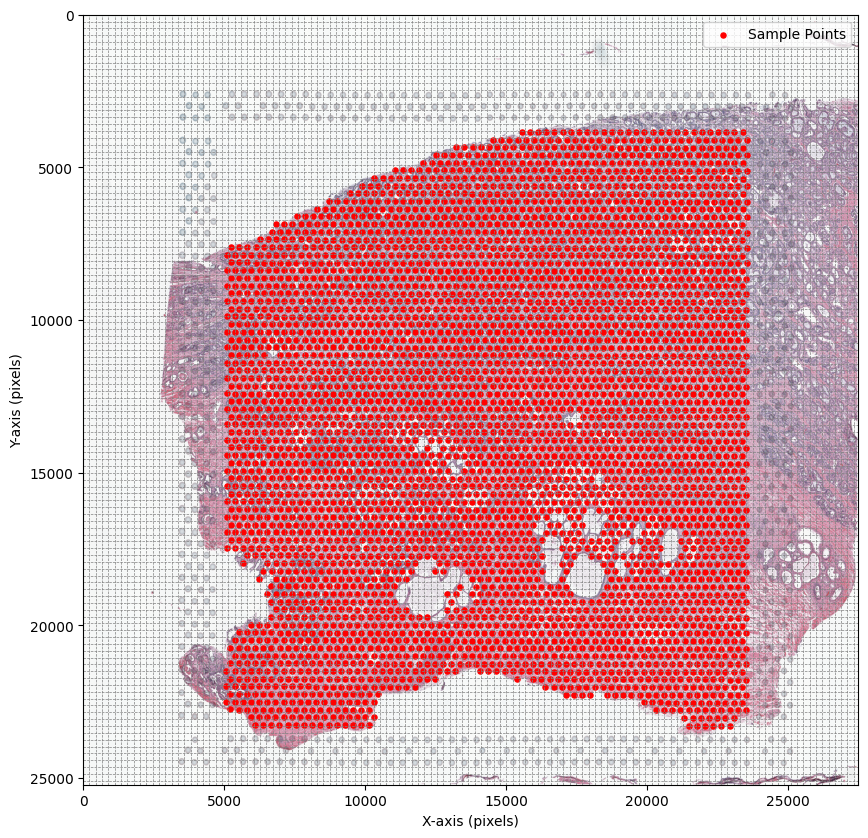

In [9]:
image_path = "spatial/tissue_hires_image.png"
visualize_tissue_image_with_samples(image_path, df, 27482, 25219)

# Final Test Set Evaluation

Now that we've developed and tuned our models using the validation set, we can perform final evaluation on the test set. This gives us an unbiased estimate of model performance.

In [10]:
# Final evaluation on test set for DNN models
print("=== FINAL TEST SET EVALUATION - DNN MODELS ===")

# Get original labels
original_labels = labelEncoder.classes_.tolist()

# Evaluate DNN models with PCA on test set
test_results_dnn = []
for i, dnn_model in enumerate(dnn_list):
    X_test_tensor = torch.tensor(X_test_pcaList[i]).float()
    with torch.no_grad():
        dnn_outputs = dnn_model(X_test_tensor)
        dnn_preds_enc = F.softmax(dnn_outputs, dim=1).argmax(dim=1)
    
    predicted_labels = [original_labels[label] for label in dnn_preds_enc.numpy()]
    
    # Calculate test metrics
    from sklearn.metrics import adjusted_rand_score, f1_score
    test_ari = adjusted_rand_score(y_test, predicted_labels)
    test_f1 = f1_score(y_test, predicted_labels, average='weighted')
    
    # Calculate test accuracy manually
    correct = (dnn_preds_enc.numpy() == y_test).sum()
    test_accuracy = correct / len(y_test)
    
    test_results_dnn.append({
        'model': f'dnn_pca_{i+1}',
        'test_accuracy': test_accuracy,
        'test_ari': test_ari,
        'test_f1': test_f1
    })
    
    print(f"DNN PCA {i+1} - Test Accuracy: {test_accuracy:.3f}, ARI: {test_ari:.3f}, F1: {test_f1:.3f}")

# Evaluate DNN without PCA on test set
X_test_tensor = torch.tensor(X_test).float()
with torch.no_grad():
    dnn_outputs = dnn_without_pca(X_test_tensor)
    dnn_preds_enc = F.softmax(dnn_outputs, dim=1).argmax(dim=1)

predicted_labels = [original_labels[label] for label in dnn_preds_enc.numpy()]
test_ari = adjusted_rand_score(y_test, predicted_labels)
test_f1 = f1_score(y_test, predicted_labels, average='weighted')
correct = (dnn_preds_enc.numpy() == y_test).sum()
test_accuracy = correct / len(y_test)

test_results_dnn.append({
    'model': 'dnn_without_pca',
    'test_accuracy': test_accuracy,
    'test_ari': test_ari,
    'test_f1': test_f1
})

print(f"DNN without PCA - Test Accuracy: {test_accuracy:.3f}, ARI: {test_ari:.3f}, F1: {test_f1:.3f}")

=== FINAL TEST SET EVALUATION - DNN MODELS ===
DNN PCA 1 - Test Accuracy: 0.880, ARI: 0.768, F1: 0.879
DNN PCA 2 - Test Accuracy: 0.877, ARI: 0.767, F1: 0.875
DNN PCA 3 - Test Accuracy: 0.872, ARI: 0.759, F1: 0.871
DNN PCA 4 - Test Accuracy: 0.866, ARI: 0.744, F1: 0.867
DNN without PCA - Test Accuracy: 0.886, ARI: 0.778, F1: 0.886


In [11]:
# Final evaluation on test set for CNN models
print("\n=== FINAL TEST SET EVALUATION - CNN MODELS ===")

# Evaluate CNN models with PCA on test set
test_results_cnn = []
for i, cnn_model in enumerate(cnn_list):
    X_test_tensor = torch.tensor(X_test_pcaList[i]).float()
    with torch.no_grad():
        cnn_outputs = cnn_model(X_test_tensor.unsqueeze(1))  # Add channel dimension for CNN
        cnn_preds_enc = F.softmax(cnn_outputs, dim=1).argmax(dim=1)
    
    predicted_labels = [original_labels[label] for label in cnn_preds_enc.numpy()]
    
    # Calculate test metrics
    test_ari = adjusted_rand_score(y_test, predicted_labels)
    test_f1 = f1_score(y_test, predicted_labels, average='weighted')
    
    # Calculate test accuracy manually
    correct = (cnn_preds_enc.numpy() == y_test).sum()
    test_accuracy = correct / len(y_test)
    
    test_results_cnn.append({
        'model': f'cnn_pca_{i+1}',
        'test_accuracy': test_accuracy,
        'test_ari': test_ari,
        'test_f1': test_f1
    })
    
    print(f"CNN PCA {i+1} - Test Accuracy: {test_accuracy:.3f}, ARI: {test_ari:.3f}, F1: {test_f1:.3f}")

# Evaluate CNN without PCA on test set
X_test_tensor = torch.tensor(X_test).float()
with torch.no_grad():
    cnn_outputs = cnn_without_pca(X_test_tensor.unsqueeze(1))  # Add channel dimension
    cnn_preds_enc = F.softmax(cnn_outputs, dim=1).argmax(dim=1)

predicted_labels = [original_labels[label] for label in cnn_preds_enc.numpy()]
test_ari = adjusted_rand_score(y_test, predicted_labels)
test_f1 = f1_score(y_test, predicted_labels, average='weighted')
correct = (cnn_preds_enc.numpy() == y_test).sum()
test_accuracy = correct / len(y_test)

test_results_cnn.append({
    'model': 'cnn_without_pca',
    'test_accuracy': test_accuracy,
    'test_ari': test_ari,
    'test_f1': test_f1
})

print(f"CNN without PCA - Test Accuracy: {test_accuracy:.3f}, ARI: {test_ari:.3f}, F1: {test_f1:.3f}")

# Save combined test results
print("\n=== SAVING FINAL TEST RESULTS ===")

# Combine all test results
all_test_results = test_results_dnn + test_results_cnn

# Save to CSV
test_results_df = pd.DataFrame(all_test_results)
test_csv_path = f"results/{result_subfolder}/final_test_scores.csv"
test_results_df.to_csv(test_csv_path, index=False)

print(f"Final test results saved to: {test_csv_path}")
print("\nFinal Test Results Summary:")
print(test_results_df.to_string(index=False))


=== FINAL TEST SET EVALUATION - CNN MODELS ===
CNN PCA 1 - Test Accuracy: 0.826, ARI: 0.682, F1: 0.822
CNN PCA 2 - Test Accuracy: 0.834, ARI: 0.691, F1: 0.830
CNN PCA 3 - Test Accuracy: 0.838, ARI: 0.696, F1: 0.834
CNN PCA 4 - Test Accuracy: 0.831, ARI: 0.691, F1: 0.824
CNN without PCA - Test Accuracy: 0.878, ARI: 0.756, F1: 0.877

=== SAVING FINAL TEST RESULTS ===
Final test results saved to: results/leiden_0.3_adenocarcinoma_224/final_test_scores.csv

Final Test Results Summary:
          model  test_accuracy  test_ari  test_f1
      dnn_pca_1       0.880000  0.767869 0.879212
      dnn_pca_2       0.876571  0.766796 0.874592
      dnn_pca_3       0.872000  0.759291 0.870633
      dnn_pca_4       0.866286  0.743917 0.866828
dnn_without_pca       0.885714  0.778204 0.885529
      cnn_pca_1       0.826286  0.682475 0.821564
      cnn_pca_2       0.834286  0.690576 0.830065
      cnn_pca_3       0.837714  0.696307 0.833989
      cnn_pca_4       0.830857  0.690735 0.824170
cnn_without_p

# Part 2: Confidence-based Training Pipeline (from train_with_conf.ipynb)

This section implements training with confidence-weighted samples, where each training sample has an associated confidence score indicating how certain we are about its label.

In [12]:
# Import confidence-based model builder
from model_builder_with_conf import create_dnn_model as create_dnn_model_conf, create_cnn_model as create_cnn_model_conf
from model_builder_with_conf import SimpleDNN as SimpleDNN_conf, SimpleCNN as SimpleCNN_conf
from plotter_standard import visualize_tissue_image_with_samples, visualize_tissue_image_with_samples_color_labels

# Configuration for confidence-based training
input_csv_conf = "training_data/WSI_patch_embeddings_standard-224_adenocarcinoma_leiden_0.3_training-data.csv"
df_conf = pd.read_csv(input_csv_conf)

# Settings for confidence-based training
do_pca_conf = True
pca_dimensions_conf = [0.8, 0.85, 0.9, 0.95]  # Different format from main pipeline
epochs_conf = 30
output_base_path_conf = "models/conf_weighted/"
ebbeding_dim_conf = 1536
result_subfolder_conf = "leiden_0.3_adenocarcinoma_224_confidence"

print(f"Confidence-based dataset shape: {df_conf.shape}")
print(f"Columns in confidence dataset: {df_conf.columns.tolist()}")

Confidence-based dataset shape: (6551, 1540)
Columns in confidence dataset: ['Patch_X', 'Patch_Y', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64', '65', '66', '67', '68', '69', '70', '71', '72', '73', '74', '75', '76', '77', '78', '79', '80', '81', '82', '83', '84', '85', '86', '87', '88', '89', '90', '91', '92', '93', '94', '95', '96', '97', '98', '99', '100', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '14

## Prepare Confidence-based Training Data

In [13]:
# Prepare features and labels for confidence-based training
feature_cols_conf = [str(i) for i in range(1536)]
X_conf = df_conf[feature_cols_conf].values.astype(np.float32)

# Standardize features
scaler_conf = StandardScaler()
X_conf = scaler_conf.fit_transform(X_conf).astype(np.float32)
y_conf = LabelEncoder().fit_transform(df_conf['label'].values).astype(np.int64)
labelEncoder_conf = LabelEncoder().fit(df_conf['label'].values)

# Extract confidence scores - required column
if 'confidence' not in df_conf.columns:
    raise ValueError("Expected 'confidence' column not found in the dataset!")

confidence_scores = df_conf['confidence'].values.astype(np.float32)
print(f"Using confidence scores. Range: {confidence_scores.min():.3f} - {confidence_scores.max():.3f}")
print(f"Mean confidence: {confidence_scores.mean():.3f}")

# Create train/validation/test splits for confidence-based training (60/20/20 split like main pipeline)
# We need to preserve indices to map back to original dataframe for visualization
indices = np.arange(len(X_conf))
X_temp_conf, X_test_conf, y_temp_conf, y_test_conf, idx_temp, idx_test = train_test_split(
    X_conf, y_conf, indices, test_size=0.2, random_state=42, stratify=y_conf)
X_train_conf, X_val_conf, y_train_conf, y_val_conf, idx_train, idx_val = train_test_split(
    X_temp_conf, y_temp_conf, idx_temp, test_size=0.25, random_state=42, stratify=y_temp_conf)  # 0.25 * 0.8 = 0.2

# Split confidence scores accordingly
conf_temp, conf_test = train_test_split(
    confidence_scores, test_size=0.2, random_state=42, stratify=y_conf)
conf_train, conf_val = train_test_split(
    conf_temp, test_size=0.25, random_state=42, stratify=y_temp_conf)

print(f"Confidence training set size: {X_train_conf.shape[0]} ({X_train_conf.shape[0]/len(X_conf)*100:.1f}%)")
print(f"Confidence validation set size: {X_val_conf.shape[0]} ({X_val_conf.shape[0]/len(X_conf)*100:.1f}%)")
print(f"Confidence test set size: {X_test_conf.shape[0]} ({X_test_conf.shape[0]/len(X_conf)*100:.1f}%)")

# Prepare PCA transformations for confidence-based training
X_pcaList_conf = []
X_val_pcaList_conf = []
X_test_pcaList_conf = []

for d in pca_dimensions_conf:
    # Initialize PCA with the specified number of components
    pca_conf = PCA(n_components=d)
    X_train_pca_conf = pca_conf.fit_transform(X_train_conf)
    X_val_pca_conf = pca_conf.transform(X_val_conf)
    X_test_pca_conf = pca_conf.transform(X_test_conf)
    
    actual_variance = pca_conf.explained_variance_ratio_.sum()
    print(f"PCA with {d} components explains {actual_variance:.3f} ({actual_variance*100:.1f}%) variance")
    print(f"Shape: {X_train_pca_conf.shape}")
    
    X_pcaList_conf.append(X_train_pca_conf)
    X_val_pcaList_conf.append(X_val_pca_conf)
    X_test_pcaList_conf.append(X_test_pca_conf)

Using confidence scores. Range: 0.017 - 1.000
Mean confidence: 0.639
Confidence training set size: 3930 (60.0%)
Confidence validation set size: 1310 (20.0%)
Confidence test set size: 1311 (20.0%)
PCA with 0.8 components explains 0.800 (80.0%) variance
Shape: (3930, 145)
PCA with 0.85 components explains 0.850 (85.0%) variance
Shape: (3930, 208)
PCA with 0.9 components explains 0.900 (90.0%) variance
Shape: (3930, 315)
PCA with 0.95 components explains 0.950 (95.0%) variance
Shape: (3930, 530)


## Train Confidence-weighted DNN Models

In [14]:
# Create results directory for confidence-based models
os.makedirs(output_base_path_conf, exist_ok=True)

# Train DNN models with confidence weighting
dnn_list_conf = []

if do_pca_conf:
    print("Training confidence-weighted DNN models with PCA...")
    for i, X_train_pca_conf in enumerate(X_pcaList_conf):
        print(f"Shape of PCA transformed data: {X_train_pca_conf.shape}")
        
        dnn_output_path_conf = f"{output_base_path_conf}/dnn_pathology_model_pca_{X_train_pca_conf.shape[1]}.pth"
        model_conf, _ = create_dnn_model_conf(
            X_train_pca_conf, X_val_pcaList_conf[i], y_train_conf, y_val_conf, 
            dnn_output_path_conf, labelEncoder_conf, 
            inputDim=X_train_pca_conf.shape[1], epochs=epochs_conf, 
            train_weights=conf_train, test_weights=conf_val)
        
        dnn_list_conf.append(model_conf)
        print(f"Training set size: {X_train_pca_conf.shape[0]}")
        print(f"Validation set size: {X_val_pcaList_conf[i].shape[0]}")
        print("")

# Train DNN without PCA with confidence weighting
dnn_output_path_conf = f"{output_base_path_conf}/dnn_pathology_model_without_pca.pth"
dnn_without_pca_conf, _ = create_dnn_model_conf(
    X_train_conf, X_val_conf, y_train_conf, y_val_conf, dnn_output_path_conf, 
    labelEncoder_conf, inputDim=ebbeding_dim_conf, epochs=epochs_conf,
    train_weights=conf_train, test_weights=conf_val)

print(f"Training set size: {X_train_conf.shape[0]}")
print(f"Validation set size: {X_val_conf.shape[0]}")

Training confidence-weighted DNN models with PCA...
Shape of PCA transformed data: (3930, 145)
Training DNN with confidence-based sample weights
DNN: Epoch 1 completed. Average Loss: 0.6078
DNN: Epoch 2 completed. Average Loss: 0.3657
DNN: Epoch 3 completed. Average Loss: 0.3091
DNN: Epoch 4 completed. Average Loss: 0.2784
DNN: Epoch 5 completed. Average Loss: 0.2590
DNN: Epoch 6 completed. Average Loss: 0.2400
DNN: Epoch 7 completed. Average Loss: 0.2328
DNN: Epoch 8 completed. Average Loss: 0.2141
DNN: Epoch 9 completed. Average Loss: 0.2118
DNN: Epoch 10 completed. Average Loss: 0.1874
DNN: Epoch 11 completed. Average Loss: 0.1856
DNN: Epoch 12 completed. Average Loss: 0.1797
DNN: Epoch 13 completed. Average Loss: 0.1716
DNN: Epoch 14 completed. Average Loss: 0.1677
DNN: Epoch 15 completed. Average Loss: 0.1597
DNN: Epoch 16 completed. Average Loss: 0.1561
DNN: Epoch 17 completed. Average Loss: 0.1477
DNN: Epoch 18 completed. Average Loss: 0.1498
DNN: Epoch 19 completed. Average Los

## Train Confidence-weighted CNN Models

In [15]:
# Train CNN models with confidence weighting
cnn_list_conf = []

if do_pca_conf:
    print("Training confidence-weighted CNN models with PCA...")
    for i, X_train_pca_conf in enumerate(X_pcaList_conf):
        print(f"Shape of PCA transformed data: {X_train_pca_conf.shape}")
        
        cnn_output_path_conf = f"{output_base_path_conf}/cnn_pathology_model_pca_{X_train_pca_conf.shape[1]}.pth"
        model_conf, _ = create_cnn_model_conf(
            X_train_pca_conf, X_val_pcaList_conf[i], y_train_conf, y_val_conf, 
            cnn_output_path_conf, labelEncoder_conf, 
            inputDim=X_train_pca_conf.shape[1], epochs=epochs_conf, 
            train_weights=conf_train, test_weights=conf_val)
        
        cnn_list_conf.append(model_conf)
        print(f"Training set size: {X_train_pca_conf.shape[0]}")
        print(f"Validation set size: {X_val_pcaList_conf[i].shape[0]}")
        print("")

# Train CNN without PCA with confidence weighting
cnn_output_path_conf = f"{output_base_path_conf}/cnn_pathology_model_without_pca.pth"
cnn_without_pca_conf, _ = create_cnn_model_conf(
    X_train_conf, X_val_conf, y_train_conf, y_val_conf, cnn_output_path_conf, 
    labelEncoder_conf, inputDim=ebbeding_dim_conf, epochs=epochs_conf,
    train_weights=conf_train, test_weights=conf_val)

print(f"Training set size: {X_train_conf.shape[0]}")
print(f"Validation set size: {X_val_conf.shape[0]}")

Training confidence-weighted CNN models with PCA...
Shape of PCA transformed data: (3930, 145)
Training CNN with confidence-based sample weights
CNN: Epoch 1 completed. Average Loss: 0.9732
CNN: Epoch 2 completed. Average Loss: 0.7491
CNN: Epoch 3 completed. Average Loss: 0.6934
CNN: Epoch 4 completed. Average Loss: 0.6428
CNN: Epoch 5 completed. Average Loss: 0.5981
CNN: Epoch 6 completed. Average Loss: 0.5833
CNN: Epoch 7 completed. Average Loss: 0.5557
CNN: Epoch 8 completed. Average Loss: 0.5441
CNN: Epoch 9 completed. Average Loss: 0.5203
CNN: Epoch 10 completed. Average Loss: 0.5161
CNN: Epoch 11 completed. Average Loss: 0.5023
CNN: Epoch 12 completed. Average Loss: 0.5047
CNN: Epoch 13 completed. Average Loss: 0.4971
CNN: Epoch 14 completed. Average Loss: 0.5017
CNN: Epoch 15 completed. Average Loss: 0.4844
CNN: Epoch 16 completed. Average Loss: 0.4738
CNN: Epoch 17 completed. Average Loss: 0.4844
CNN: Epoch 18 completed. Average Loss: 0.4755
CNN: Epoch 19 completed. Average Los

In [16]:
# Evaluate confidence-weighted models on validation set
print("=== CONFIDENCE-WEIGHTED MODEL VALIDATION EVALUATION ===")

# Get original labels from confidence model
original_labels_conf = labelEncoder_conf.classes_.tolist()

# Evaluate DNN models with confidence weighting on validation set
list_of_predicted_labels_dnn_conf_val = []
ari_score_list_dnn_conf_val = []
f1_score_list_dnn_conf_val = []
accuracy_list_dnn_conf_val = []

print("Evaluating confidence-weighted DNN models on validation set:")
for i, dnn_model_conf in enumerate(dnn_list_conf):
    # Get validation predictions for each confidence DNN model
    X_val_tensor_conf = torch.tensor(X_val_pcaList_conf[i]).float()
    with torch.no_grad():
        dnn_outputs_temp = dnn_model_conf(X_val_tensor_conf)
        temp = F.softmax(dnn_outputs_temp, dim=1).argmax(dim=1)
        # List comprehension of predicted labels
        predicted_labels = [original_labels_conf[label] for label in temp.numpy()]
        list_of_predicted_labels_dnn_conf_val.append(predicted_labels)
    
    # Calculate validation metrics
    ari_score = adjusted_rand_score(y_val_conf, predicted_labels)
    f1_score_val = f1_score(y_val_conf, predicted_labels, average='weighted')
    accuracy_val = accuracy_score(y_val_conf, predicted_labels)
    
    ari_score_list_dnn_conf_val.append(ari_score)
    f1_score_list_dnn_conf_val.append(f1_score_val)
    accuracy_list_dnn_conf_val.append(accuracy_val)
    
    print(f"Confidence DNN PCA {i+1} - Validation Accuracy: {accuracy_val:.3f}, ARI: {ari_score:.3f}, F1: {f1_score_val:.3f}")

# Evaluate confidence DNN without PCA on validation set
X_val_tensor_conf = torch.tensor(X_val_conf).float()
with torch.no_grad():
    dnn_outputs = dnn_without_pca_conf(X_val_tensor_conf)
    dnn_preds_enc = F.softmax(dnn_outputs, dim=1).argmax(dim=1)
predicted_labels_dnn_no_pca_conf_val = [original_labels_conf[label] for label in dnn_preds_enc.numpy()]

# Calculate validation metrics for confidence DNN without PCA
ari_dnn_no_pca_conf_val = adjusted_rand_score(y_val_conf, predicted_labels_dnn_no_pca_conf_val)
f1_dnn_no_pca_conf_val = f1_score(y_val_conf, predicted_labels_dnn_no_pca_conf_val, average='weighted')
accuracy_dnn_no_pca_conf_val = accuracy_score(y_val_conf, predicted_labels_dnn_no_pca_conf_val)

print(f"Confidence DNN without PCA - Validation Accuracy: {accuracy_dnn_no_pca_conf_val:.3f}, ARI: {ari_dnn_no_pca_conf_val:.3f}, F1: {f1_dnn_no_pca_conf_val:.3f}")

# Evaluate confidence-weighted CNN models on validation set
list_of_predicted_labels_cnn_conf_val = []
ari_score_list_cnn_conf_val = []
f1_score_list_cnn_conf_val = []
accuracy_list_cnn_conf_val = []

print("\nEvaluating confidence-weighted CNN models on validation set:")
for i, cnn_model_conf in enumerate(cnn_list_conf):
    # Get validation predictions for each confidence CNN model
    X_val_tensor_conf = torch.tensor(X_val_pcaList_conf[i]).float()
    with torch.no_grad():
        cnn_outputs_temp = cnn_model_conf(X_val_tensor_conf.unsqueeze(1))  # Add channel dimension for CNN
        temp = F.softmax(cnn_outputs_temp, dim=1).argmax(dim=1)
        # List comprehension of predicted labels
        predicted_labels = [original_labels_conf[label] for label in temp.numpy()]
        list_of_predicted_labels_cnn_conf_val.append(predicted_labels)
    
    # Calculate validation metrics
    ari_score = adjusted_rand_score(y_val_conf, predicted_labels)
    f1_score_val = f1_score(y_val_conf, predicted_labels, average='weighted')
    accuracy_val = accuracy_score(y_val_conf, predicted_labels)
    
    ari_score_list_cnn_conf_val.append(ari_score)
    f1_score_list_cnn_conf_val.append(f1_score_val)
    accuracy_list_cnn_conf_val.append(accuracy_val)
    
    print(f"Confidence CNN PCA {i+1} - Validation Accuracy: {accuracy_val:.3f}, ARI: {ari_score:.3f}, F1: {f1_score_val:.3f}")

# Evaluate confidence CNN without PCA on validation set
X_val_tensor_conf = torch.tensor(X_val_conf).float()
with torch.no_grad():
    cnn_outputs = cnn_without_pca_conf(X_val_tensor_conf.unsqueeze(1))  # Add channel dimension
    cnn_preds_enc = F.softmax(cnn_outputs, dim=1).argmax(dim=1)
predicted_labels_cnn_no_pca_conf_val = [original_labels_conf[label] for label in cnn_preds_enc.numpy()]

# Calculate validation metrics for confidence CNN without PCA
ari_cnn_no_pca_conf_val = adjusted_rand_score(y_val_conf, predicted_labels_cnn_no_pca_conf_val)
f1_cnn_no_pca_conf_val = f1_score(y_val_conf, predicted_labels_cnn_no_pca_conf_val, average='weighted')
accuracy_cnn_no_pca_conf_val = accuracy_score(y_val_conf, predicted_labels_cnn_no_pca_conf_val)

print(f"Confidence CNN without PCA - Validation Accuracy: {accuracy_cnn_no_pca_conf_val:.3f}, ARI: {ari_cnn_no_pca_conf_val:.3f}, F1: {f1_cnn_no_pca_conf_val:.3f}")

=== CONFIDENCE-WEIGHTED MODEL VALIDATION EVALUATION ===
Evaluating confidence-weighted DNN models on validation set:
Confidence DNN PCA 1 - Validation Accuracy: 0.848, ARI: 0.709, F1: 0.849
Confidence DNN PCA 2 - Validation Accuracy: 0.847, ARI: 0.707, F1: 0.847
Confidence DNN PCA 3 - Validation Accuracy: 0.853, ARI: 0.720, F1: 0.855
Confidence DNN PCA 4 - Validation Accuracy: 0.844, ARI: 0.704, F1: 0.846
Confidence DNN without PCA - Validation Accuracy: 0.853, ARI: 0.713, F1: 0.853

Evaluating confidence-weighted CNN models on validation set:
Confidence CNN PCA 1 - Validation Accuracy: 0.799, ARI: 0.630, F1: 0.798
Confidence CNN PCA 2 - Validation Accuracy: 0.807, ARI: 0.642, F1: 0.806
Confidence CNN PCA 3 - Validation Accuracy: 0.811, ARI: 0.647, F1: 0.810
Confidence CNN PCA 4 - Validation Accuracy: 0.809, ARI: 0.645, F1: 0.807
Confidence CNN without PCA - Validation Accuracy: 0.850, ARI: 0.716, F1: 0.850


## Confidence-weighted Validation Results Summary

This section summarizes the **validation accuracy** for all confidence-weighted models. These models use confidence scores during training to weight the importance of each sample, and validation accuracy shows how well they generalize to unseen data.

In [17]:
# Create validation results summary for confidence-weighted pipeline
print("=== CONFIDENCE-WEIGHTED VALIDATION RESULTS SUMMARY ===")

# Compile all confidence-weighted validation results
confidence_validation_results = []

# Add DNN results with PCA
for i in range(len(dnn_list_conf)):
    confidence_validation_results.append({
        'model': f'conf_dnn_pca_{i+1}',
        'architecture': 'DNN',
        'pca_components': pca_dimensions_conf[i],
        'validation_accuracy': accuracy_list_dnn_conf_val[i],
        'validation_ari': ari_score_list_dnn_conf_val[i],
        'validation_f1': f1_score_list_dnn_conf_val[i],
        'confidence_weighted': True
    })

# Add DNN without PCA
confidence_validation_results.append({
    'model': 'conf_dnn_without_pca',
    'architecture': 'DNN',
    'pca_components': 'None',
    'validation_accuracy': accuracy_dnn_no_pca_conf_val,
    'validation_ari': ari_dnn_no_pca_conf_val,
    'validation_f1': f1_dnn_no_pca_conf_val,
    'confidence_weighted': True
})

# Add CNN results with PCA
for i in range(len(cnn_list_conf)):
    confidence_validation_results.append({
        'model': f'conf_cnn_pca_{i+1}',
        'architecture': 'CNN',
        'pca_components': pca_dimensions_conf[i],
        'validation_accuracy': accuracy_list_cnn_conf_val[i],
        'validation_ari': ari_score_list_cnn_conf_val[i],
        'validation_f1': f1_score_list_cnn_conf_val[i],
        'confidence_weighted': True
    })

# Add CNN without PCA
confidence_validation_results.append({
    'model': 'conf_cnn_without_pca',
    'architecture': 'CNN',
    'pca_components': 'None',
    'validation_accuracy': accuracy_cnn_no_pca_conf_val,
    'validation_ari': ari_cnn_no_pca_conf_val,
    'validation_f1': f1_cnn_no_pca_conf_val,
    'confidence_weighted': True
})

# Create DataFrame and save results
confidence_validation_results_df = pd.DataFrame(confidence_validation_results)
confidence_validation_csv_path = f"results/{result_subfolder_conf}/confidence_weighted_validation_results.csv"

# Create results directory for confidence models
results_dir_conf = f"results/{result_subfolder_conf}"
os.makedirs(results_dir_conf, exist_ok=True)

confidence_validation_results_df.to_csv(confidence_validation_csv_path, index=False)

print(f"Confidence-weighted validation results saved to: {confidence_validation_csv_path}")
print("\nConfidence-weighted Validation Results Summary:")
print(confidence_validation_results_df.to_string(index=False))

=== CONFIDENCE-WEIGHTED VALIDATION RESULTS SUMMARY ===
Confidence-weighted validation results saved to: results/leiden_0.3_adenocarcinoma_224_confidence/confidence_weighted_validation_results.csv

Confidence-weighted Validation Results Summary:
               model architecture pca_components  validation_accuracy  validation_ari  validation_f1  confidence_weighted
      conf_dnn_pca_1          DNN            0.8             0.848092        0.708619       0.848852                 True
      conf_dnn_pca_2          DNN           0.85             0.846565        0.707025       0.847242                 True
      conf_dnn_pca_3          DNN            0.9             0.853435        0.720323       0.854505                 True
      conf_dnn_pca_4          DNN           0.95             0.844275        0.704257       0.845640                 True
conf_dnn_without_pca          DNN           None             0.852672        0.712681       0.853233                 True
      conf_cnn_pca_1   

# Final Test Set Evaluation - Confidence-weighted Models

Final evaluation of confidence-weighted models on the test set for unbiased performance estimation.

In [18]:
# Final evaluation on test set for confidence-weighted DNN models
print("=== FINAL TEST SET EVALUATION - CONFIDENCE-WEIGHTED DNN MODELS ===")

# Get original labels
original_labels_conf = labelEncoder_conf.classes_.tolist()

# Evaluate confidence DNN models with PCA on test set
test_results_dnn_conf = []
for i, dnn_model_conf in enumerate(dnn_list_conf):
    X_test_tensor_conf = torch.tensor(X_test_pcaList_conf[i]).float()
    with torch.no_grad():
        dnn_outputs = dnn_model_conf(X_test_tensor_conf)
        dnn_preds_enc = F.softmax(dnn_outputs, dim=1).argmax(dim=1)
    
    predicted_labels = [original_labels_conf[label] for label in dnn_preds_enc.numpy()]
    
    # Calculate test metrics
    test_ari = adjusted_rand_score(y_test_conf, predicted_labels)
    test_f1 = f1_score(y_test_conf, predicted_labels, average='weighted')
    
    # Calculate test accuracy manually
    correct = (dnn_preds_enc.numpy() == y_test_conf).sum()
    test_accuracy = correct / len(y_test_conf)
    
    test_results_dnn_conf.append({
        'model': f'conf_dnn_pca_{i+1}',
        'test_accuracy': test_accuracy,
        'test_ari': test_ari,
        'test_f1': test_f1
    })
    
    print(f"Confidence DNN PCA {i+1} - Test Accuracy: {test_accuracy:.3f}, ARI: {test_ari:.3f}, F1: {test_f1:.3f}")

# Evaluate confidence DNN without PCA on test set
X_test_tensor_conf = torch.tensor(X_test_conf).float()
with torch.no_grad():
    dnn_outputs = dnn_without_pca_conf(X_test_tensor_conf)
    dnn_preds_enc = F.softmax(dnn_outputs, dim=1).argmax(dim=1)

predicted_labels = [original_labels_conf[label] for label in dnn_preds_enc.numpy()]
test_ari = adjusted_rand_score(y_test_conf, predicted_labels)
test_f1 = f1_score(y_test_conf, predicted_labels, average='weighted')
correct = (dnn_preds_enc.numpy() == y_test_conf).sum()
test_accuracy = correct / len(y_test_conf)

test_results_dnn_conf.append({
    'model': 'conf_dnn_without_pca',
    'test_accuracy': test_accuracy,
    'test_ari': test_ari,
    'test_f1': test_f1
})

print(f"Confidence DNN without PCA - Test Accuracy: {test_accuracy:.3f}, ARI: {test_ari:.3f}, F1: {test_f1:.3f}")

=== FINAL TEST SET EVALUATION - CONFIDENCE-WEIGHTED DNN MODELS ===
Confidence DNN PCA 1 - Test Accuracy: 0.851, ARI: 0.717, F1: 0.851
Confidence DNN PCA 2 - Test Accuracy: 0.842, ARI: 0.698, F1: 0.841
Confidence DNN PCA 3 - Test Accuracy: 0.844, ARI: 0.703, F1: 0.844
Confidence DNN PCA 4 - Test Accuracy: 0.836, ARI: 0.689, F1: 0.834
Confidence DNN without PCA - Test Accuracy: 0.847, ARI: 0.712, F1: 0.845


In [19]:
# Final evaluation on test set for confidence-weighted CNN models
print("\n=== FINAL TEST SET EVALUATION - CONFIDENCE-WEIGHTED CNN MODELS ===")

# Evaluate confidence CNN models with PCA on test set
test_results_cnn_conf = []
for i, cnn_model_conf in enumerate(cnn_list_conf):
    X_test_tensor_conf = torch.tensor(X_test_pcaList_conf[i]).float()
    with torch.no_grad():
        cnn_outputs = cnn_model_conf(X_test_tensor_conf.unsqueeze(1))  # Add channel dimension for CNN
        cnn_preds_enc = F.softmax(cnn_outputs, dim=1).argmax(dim=1)
    
    predicted_labels = [original_labels_conf[label] for label in cnn_preds_enc.numpy()]
    
    # Calculate test metrics
    test_ari = adjusted_rand_score(y_test_conf, predicted_labels)
    test_f1 = f1_score(y_test_conf, predicted_labels, average='weighted')
    
    # Calculate test accuracy manually
    correct = (cnn_preds_enc.numpy() == y_test_conf).sum()
    test_accuracy = correct / len(y_test_conf)
    
    test_results_cnn_conf.append({
        'model': f'conf_cnn_pca_{i+1}',
        'test_accuracy': test_accuracy,
        'test_ari': test_ari,
        'test_f1': test_f1
    })
    
    print(f"Confidence CNN PCA {i+1} - Test Accuracy: {test_accuracy:.3f}, ARI: {test_ari:.3f}, F1: {test_f1:.3f}")

# Evaluate confidence CNN without PCA on test set
X_test_tensor_conf = torch.tensor(X_test_conf).float()
with torch.no_grad():
    cnn_outputs = cnn_without_pca_conf(X_test_tensor_conf.unsqueeze(1))  # Add channel dimension
    cnn_preds_enc = F.softmax(cnn_outputs, dim=1).argmax(dim=1)

predicted_labels = [original_labels_conf[label] for label in cnn_preds_enc.numpy()]
test_ari = adjusted_rand_score(y_test_conf, predicted_labels)
test_f1 = f1_score(y_test_conf, predicted_labels, average='weighted')
correct = (cnn_preds_enc.numpy() == y_test_conf).sum()
test_accuracy = correct / len(y_test_conf)

test_results_cnn_conf.append({
    'model': 'conf_cnn_without_pca',
    'test_accuracy': test_accuracy,
    'test_ari': test_ari,
    'test_f1': test_f1
})

print(f"Confidence CNN without PCA - Test Accuracy: {test_accuracy:.3f}, ARI: {test_ari:.3f}, F1: {test_f1:.3f}")

# Save combined confidence test results
print("\n=== SAVING CONFIDENCE-WEIGHTED FINAL TEST RESULTS ===")

# Combine all confidence test results
all_test_results_conf = test_results_dnn_conf + test_results_cnn_conf

# Save to CSV
test_results_conf_df = pd.DataFrame(all_test_results_conf)
test_csv_path_conf = f"results/{result_subfolder_conf}/final_test_scores_confidence_weighted.csv"
test_results_conf_df.to_csv(test_csv_path_conf, index=False)

print(f"Confidence-weighted final test results saved to: {test_csv_path_conf}")
print("\nConfidence-weighted Final Test Results Summary:")
print(test_results_conf_df.to_string(index=False))


=== FINAL TEST SET EVALUATION - CONFIDENCE-WEIGHTED CNN MODELS ===
Confidence CNN PCA 1 - Test Accuracy: 0.802, ARI: 0.628, F1: 0.799
Confidence CNN PCA 2 - Test Accuracy: 0.798, ARI: 0.625, F1: 0.794
Confidence CNN PCA 3 - Test Accuracy: 0.801, ARI: 0.629, F1: 0.796
Confidence CNN PCA 4 - Test Accuracy: 0.805, ARI: 0.635, F1: 0.800
Confidence CNN without PCA - Test Accuracy: 0.851, ARI: 0.712, F1: 0.850

=== SAVING CONFIDENCE-WEIGHTED FINAL TEST RESULTS ===
Confidence-weighted final test results saved to: results/leiden_0.3_adenocarcinoma_224_confidence/final_test_scores_confidence_weighted.csv

Confidence-weighted Final Test Results Summary:
               model  test_accuracy  test_ari  test_f1
      conf_dnn_pca_1       0.851259  0.716915 0.850849
      conf_dnn_pca_2       0.842105  0.698324 0.841133
      conf_dnn_pca_3       0.844394  0.702963 0.843509
      conf_dnn_pca_4       0.836003  0.688862 0.834137
conf_dnn_without_pca       0.846682  0.712478 0.845273
      conf_cnn_pc

## Visualize Confidence-weighted Model Predictions

Let's visualize the predictions from confidence-weighted models and analyze the relationship between confidence scores and predictions.

## Visualize Main Pipeline Model Predictions

Let's visualize the predictions from the main pipeline models for comparison with confidence-weighted models.

## Data Samples Used in Visualizations

This section explains exactly which data samples are used in each visualization and how they are prepared.

### **Visualization Overview**

Your notebook contains **3 different visualizations** using different data samples:

1. **Cell 17**: Basic sample points (all original data)
2. **Cell 37**: Main pipeline predictions (validation subset only)  
3. **Cell 39**: Confidence-weighted predictions (validation subset only)

### **Data Sources and Sample Selection**

#### **Cell 17: Basic Sample Visualization**
- **Data Source**: `df` (original main pipeline dataset)
- **File**: `"training_data/WSI_patch_embeddings_centered-224_adenocarcinoma_leiden_0.3_training-data.csv"`
- **Samples Used**: **ALL samples** in the dataset
- **Sample Count**: Full dataset (no filtering)
- **What's Shown**: Red dots at all sample locations
- **Purpose**: Overview of all sample positions on tissue

#### **Cell 37: Main Pipeline Predictions Visualization**
- **Data Source**: `df_predicted_main_val` (validation subset only)
- **Original File**: Same as above (`"training_data/WSI_patch_embeddings_centered-224_adenocarcinoma_leiden_0.3_training-data.csv"`)
- **Samples Used**: **VALIDATION SET ONLY** (20% of main dataset)
- **Sample Selection Process**:
  ```python
  # Step 1: Split main dataset (60/20/20)
  X_temp, X_test, y_temp, y_test = train_test_split(df, y, test_size=0.2, random_state=42, stratify=y)
  X_train_df, X_val_df, y_train_temp, y_val_temp = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)
  
  # Step 2: Use validation subset for visualization
  df_predicted_main_val = X_val_df[['Patch_X', 'Patch_Y']].copy()
  df_predicted_main_val['label'] = predicted_labels_dnn_no_pca  # Model predictions
  ```
- **What's Shown**: Colored patches showing DNN (no PCA) predictions for validation samples
- **Purpose**: Visualize model predictions vs actual tissue structure

#### **Cell 39: Confidence-weighted Predictions Visualization**
- **Data Source**: `df_predicted_conf_val` (validation subset only)
- **Original File**: `"WSI_patch_embeddings_standard-224_adenocarcinoma_leiden_0.3_training-data_old.csv"`
- **Samples Used**: **VALIDATION SET ONLY** (20% of confidence dataset)
- **Sample Selection Process**:
  ```python
  # Step 1: Split confidence dataset with index tracking (60/20/20)
  indices = np.arange(len(X_conf))
  X_temp_conf, X_test_conf, y_temp_conf, y_test_conf, idx_temp, idx_test = train_test_split(
      X_conf, y_conf, indices, test_size=0.2, random_state=42, stratify=y_conf)
  X_train_conf, X_val_conf, y_train_conf, y_val_conf, idx_train, idx_val = train_test_split(
      X_temp_conf, y_temp_conf, idx_temp, test_size=0.25, random_state=42, stratify=y_temp_conf)
  
  # Step 2: Use preserved indices to map back to original dataframe
  df_predicted_conf_val = df_conf.iloc[idx_val].copy()  # Use preserved validation indices
  df_predicted_conf_val['label'] = predicted_labels_dnn_no_pca_conf_val  # Model predictions
  df_predicted_conf_val['confidence'] = conf_val  # Confidence scores
  ```
- **What's Shown**: Colored patches showing confidence-weighted DNN (no PCA) predictions for validation samples
- **Purpose**: Visualize confidence-weighted model predictions and analyze confidence patterns

### **Key Differences Between Datasets**

| Aspect | Main Pipeline (Cells 17, 37) | Confidence Pipeline (Cell 39) |
|--------|-------------------------------|--------------------------------|
| **Source File** | `WSI_patch_embeddings_centered-224_adenocarcinoma_leiden_0.3_training-data.csv` | `WSI_patch_embeddings_standard-224_adenocarcinoma_leiden_0.3_training-data_old.csv` |
| **Processing** | Centered embeddings | Standard embeddings |
| **Special Columns** | None | `confidence` column with scores |
| **Visualization Samples** | Cell 17: All samples<br>Cell 37: Validation only | Cell 39: Validation only |
| **Index Tracking** | Re-splits dataframe for visualization | Preserves original indices via `idx_val` |

### **Sample Count Summary**

The exact number of samples in each visualization depends on your dataset sizes, but the proportions are:

- **Cell 17**: 100% of main dataset samples
- **Cell 37**: ~20% of main dataset samples (validation set)
- **Cell 39**: ~20% of confidence dataset samples (validation set)

### **Why Only Validation Samples for Predictions?**

The prediction visualizations (Cells 37 and 39) use only validation samples because:

1. **Unbiased Evaluation**: Validation set wasn't used for training, so predictions are unbiased
2. **Meaningful Comparison**: Both pipelines use the same 20% validation split methodology
3. **Performance Assessment**: Shows how well models generalize to unseen data
4. **Spatial Analysis**: Reveals if models learn spatial tissue patterns correctly

Visualizing main pipeline DNN predictions (without PCA) on validation set...


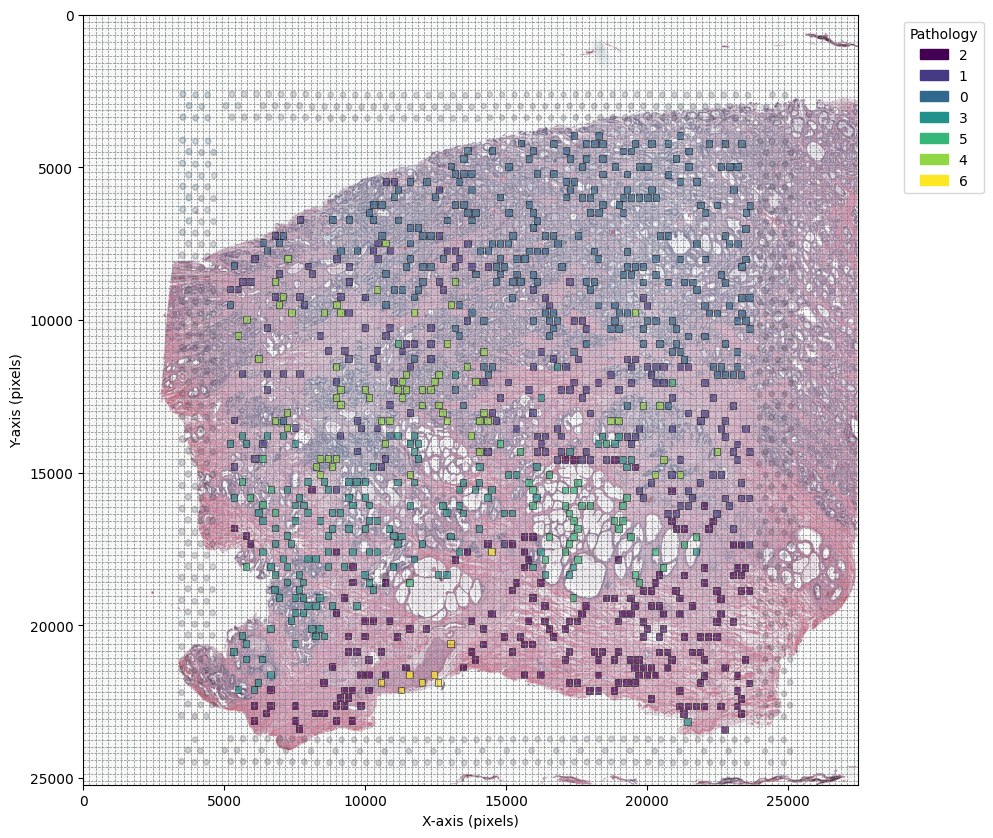

Main pipeline validation set visualization completed successfully

Main Pipeline Validation Set Prediction Analysis:
Total validation samples: 874
Unique predicted labels: 7
Label distribution:
label
0    246
2    190
1    177
3    142
4     66
5     45
6      8
Name: count, dtype: int64

Actual vs Predicted Label Distribution (Main Pipeline):
Actual labels distribution:
  0: 246
  1: 185
  2: 180
  3: 133
  4: 71
  5: 52
  6: 7
Predicted labels distribution:
  0: 246
  2: 190
  1: 177
  3: 142
  4: 66
  5: 45
  6: 8

Main Pipeline DNN (no PCA) Validation Accuracy: 0.875


In [20]:
# Visualize predictions from main pipeline DNN without PCA on validation set
print("Visualizing main pipeline DNN predictions (without PCA) on validation set...")

# Create prediction dataframe for visualization using validation predictions
# We need to map validation indices back to original dataframe
X_temp, X_test_temp, y_temp, y_test_temp = train_test_split(df, y, test_size=0.2, random_state=42, stratify=y)
X_train_df, X_val_df, y_train_temp, y_val_temp = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp)

df_predicted_main_val = X_val_df[['Patch_X', 'Patch_Y']].copy()
df_predicted_main_val['label'] = predicted_labels_dnn_no_pca  # Main pipeline predictions

# Visualize tissue with main pipeline predictions
image_path = "spatial/tissue_hires_image.png"
try:
    visualize_tissue_image_with_samples_color_labels(image_path, df_predicted_main_val, 27482, 25219)
    print("Main pipeline validation set visualization completed successfully")
except Exception as e:
    print(f"Main pipeline visualization error: {e}")
    print("Continuing with analysis...")

# Print some statistics about the main pipeline predictions
print(f"\nMain Pipeline Validation Set Prediction Analysis:")
print(f"Total validation samples: {len(df_predicted_main_val)}")
print(f"Unique predicted labels: {df_predicted_main_val['label'].nunique()}")
print(f"Label distribution:")
print(df_predicted_main_val['label'].value_counts())

# Show actual vs predicted label distribution
actual_labels_main_val = [original_labels[label] for label in y_val]
print(f"\nActual vs Predicted Label Distribution (Main Pipeline):")
print(f"Actual labels distribution:")
unique_actual, counts_actual = np.unique(actual_labels_main_val, return_counts=True)
for label, count in zip(unique_actual, counts_actual):
    print(f"  {label}: {count}")

print(f"Predicted labels distribution:")
predicted_counts = df_predicted_main_val['label'].value_counts()
for label, count in predicted_counts.items():
    print(f"  {label}: {count}")

# Calculate and show main pipeline validation accuracy
from sklearn.metrics import accuracy_score
main_val_accuracy = accuracy_score(actual_labels_main_val, predicted_labels_dnn_no_pca)
print(f"\nMain Pipeline DNN (no PCA) Validation Accuracy: {main_val_accuracy:.3f}")

In [21]:
# Compare Main Pipeline vs Confidence-weighted Predictions
print("=== COMPARISON: MAIN PIPELINE vs CONFIDENCE-WEIGHTED PREDICTIONS ===")

# Compare prediction accuracy on validation sets
print(f"\nValidation Set Performance Comparison:")
print(f"Main Pipeline DNN (no PCA):")
print(f"  - Accuracy: {accuracy_dnn_no_pca:.3f}")
print(f"  - ARI: {ari_dnn_no_pca:.3f}")
print(f"  - F1: {f1_dnn_no_pca:.3f}")

print(f"\nConfidence-weighted DNN (no PCA):")
print(f"  - Accuracy: {accuracy_dnn_no_pca_conf_val:.3f}")
print(f"  - ARI: {ari_dnn_no_pca_conf_val:.3f}")
print(f"  - F1: {f1_dnn_no_pca_conf_val:.3f}")

# Calculate improvement/difference
acc_diff = accuracy_dnn_no_pca_conf_val - accuracy_dnn_no_pca
ari_diff = ari_dnn_no_pca_conf_val - ari_dnn_no_pca
f1_diff = f1_dnn_no_pca_conf_val - f1_dnn_no_pca

print(f"\nPerformance Difference (Confidence-weighted - Main):")
print(f"  - Accuracy difference: {acc_diff:+.3f}")
print(f"  - ARI difference: {ari_diff:+.3f}")
print(f"  - F1 difference: {f1_diff:+.3f}")

if acc_diff > 0:
    print(f"\n✓ Confidence weighting improves accuracy by {acc_diff:.3f}")
elif acc_diff < 0:
    print(f"\n⚠ Confidence weighting decreases accuracy by {abs(acc_diff):.3f}")
else:
    print(f"\n→ No accuracy difference between approaches")

# Show dataset information for comparison
print(f"\nDataset Comparison:")
print(f"Main Pipeline dataset: {df.shape[0]} samples")
print(f"Confidence-weighted dataset: {df_conf.shape[0]} samples")
print(f"Training epochs: {epochs} (main) vs {epochs_conf} (confidence)")
print(f"PCA approach: Variance-based (main) vs Fixed components (confidence)")

=== COMPARISON: MAIN PIPELINE vs CONFIDENCE-WEIGHTED PREDICTIONS ===

Validation Set Performance Comparison:
Main Pipeline DNN (no PCA):
  - Accuracy: 0.875
  - ARI: 0.752
  - F1: 0.875

Confidence-weighted DNN (no PCA):
  - Accuracy: 0.853
  - ARI: 0.713
  - F1: 0.853

Performance Difference (Confidence-weighted - Main):
  - Accuracy difference: -0.023
  - ARI difference: -0.039
  - F1 difference: -0.022

⚠ Confidence weighting decreases accuracy by 0.023

Dataset Comparison:
Main Pipeline dataset: 4371 samples
Confidence-weighted dataset: 6551 samples
Training epochs: 30 (main) vs 30 (confidence)
PCA approach: Variance-based (main) vs Fixed components (confidence)


Visualizing confidence-weighted DNN predictions (without PCA) on validation set...


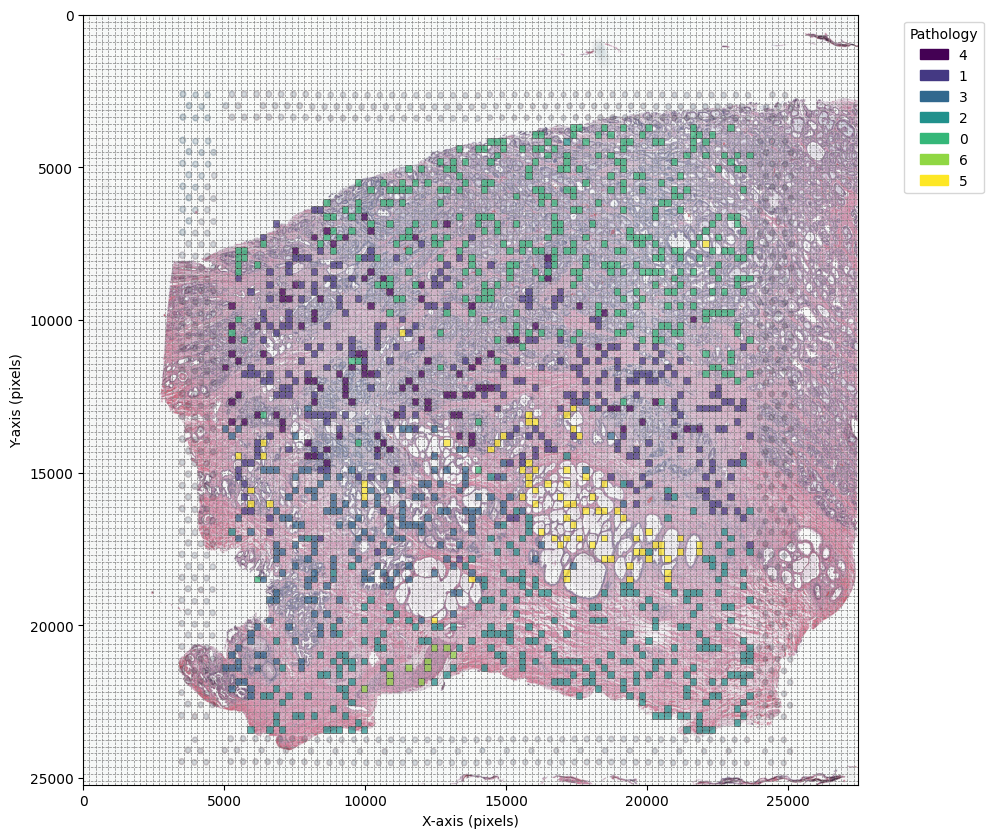

Validation set visualization completed successfully

Validation Set Prediction-Confidence Analysis:
Total validation samples: 1310
Unique predicted labels: 7
Label distribution:
label
0    366
1    287
2    273
3    186
4    112
5     76
6     10
Name: count, dtype: int64

Confidence by predicted label (validation set):
           mean       std       min  max
label                                   
0      0.644308  0.177760  0.100000  1.0
1      0.639431  0.196875  0.133333  1.0
2      0.627167  0.210370  0.033333  1.0
3      0.636380  0.177697  0.175000  1.0
4      0.628571  0.210173  0.175000  1.0
5      0.553728  0.219648  0.025000  1.0
6      0.597500  0.191810  0.241667  0.9


In [22]:
# Visualize predictions from confidence-weighted DNN without PCA on validation set
print("Visualizing confidence-weighted DNN predictions (without PCA) on validation set...")

# Create prediction dataframe for visualization using validation predictions
df_predicted_conf_val = df_conf.iloc[idx_val].copy()  # Use preserved validation indices
df_predicted_conf_val = df_predicted_conf_val[['Patch_X', 'Patch_Y']].copy()
df_predicted_conf_val['label'] = predicted_labels_dnn_no_pca_conf_val
df_predicted_conf_val['confidence'] = conf_val  # Use validation confidence scores

# Visualize tissue with confidence-weighted predictions
image_path = "spatial/tissue_hires_image.png"
try:
    visualize_tissue_image_with_samples_color_labels(image_path, df_predicted_conf_val, 27482, 25219)
    print("Validation set visualization completed successfully")
except Exception as e:
    print(f"Visualization error: {e}")
    print("Continuing with analysis...")

# Print some statistics about the predictions vs confidence
print(f"\nValidation Set Prediction-Confidence Analysis:")
print(f"Total validation samples: {len(df_predicted_conf_val)}")
print(f"Unique predicted labels: {df_predicted_conf_val['label'].nunique()}")
print(f"Label distribution:")
print(df_predicted_conf_val['label'].value_counts())

# Show confidence distribution by predicted label
print(f"\nConfidence by predicted label (validation set):")
confidence_by_label_val = df_predicted_conf_val.groupby('label')['confidence'].agg(['mean', 'std', 'min', 'max'])
print(confidence_by_label_val)

## Confidence-weighted Results Summary and Comparison

This section provides a comprehensive summary of all confidence-weighted model results and compares them with the main pipeline results.

In [23]:
# Print confidence-weighted pipeline summary
print("=== CONFIDENCE-WEIGHTED PIPELINE SUMMARY ===")

print(f"\nConfidence statistics:")
print(f"- Mean confidence: {confidence_scores.mean():.3f}")
print(f"- Confidence range: {confidence_scores.min():.3f} - {confidence_scores.max():.3f}")
print(f"- Dataset split: {X_train_conf.shape[0]} train / {X_val_conf.shape[0]} val / {X_test_conf.shape[0]} test")
print(f"- All models use confidence-weighted loss during training")

print(f"\nModel architectures trained:")
print(f"- DNN models with PCA: {len(dnn_list_conf)}")
print(f"- DNN without PCA: 1")
print(f"- CNN models with PCA: {len(cnn_list_conf)}")
print(f"- CNN without PCA: 1")
print(f"- Total confidence-weighted models: {len(dnn_list_conf) + 1 + len(cnn_list_conf) + 1}")

print(f"\nResults saved to:")
print(f"- Validation results: results/{result_subfolder_conf}/confidence_weighted_validation_results.csv")
print(f"- Test results: results/{result_subfolder_conf}/final_test_scores_confidence_weighted.csv")

=== CONFIDENCE-WEIGHTED PIPELINE SUMMARY ===

Confidence statistics:
- Mean confidence: 0.639
- Confidence range: 0.017 - 1.000
- Dataset split: 3930 train / 1310 val / 1311 test
- All models use confidence-weighted loss during training

Model architectures trained:
- DNN models with PCA: 4
- DNN without PCA: 1
- CNN models with PCA: 4
- CNN without PCA: 1
- Total confidence-weighted models: 10

Results saved to:
- Validation results: results/leiden_0.3_adenocarcinoma_224_confidence/confidence_weighted_validation_results.csv
- Test results: results/leiden_0.3_adenocarcinoma_224_confidence/final_test_scores_confidence_weighted.csv


## Visualize Confidence-weighted Model Predictions

In [24]:
# Additional visualization options and analysis can be added here
print("=== ADDITIONAL ANALYSIS OPPORTUNITIES ===")
print("1. Compare main pipeline vs confidence-weighted pipeline performance")
print("2. Analyze which samples benefit most from confidence weighting")
print("3. Study correlation between confidence scores and prediction accuracy")
print("4. Visualize confidence distribution across tissue regions")
print("5. Compare validation vs test performance for overfitting detection")


=== ADDITIONAL ANALYSIS OPPORTUNITIES ===
1. Compare main pipeline vs confidence-weighted pipeline performance
2. Analyze which samples benefit most from confidence weighting
3. Study correlation between confidence scores and prediction accuracy
4. Visualize confidence distribution across tissue regions
5. Compare validation vs test performance for overfitting detection
